In [ ]:
%%capture
 !pip install pybamm

In [ ]:
%%capture
!pip install import-ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
current_dir = os.getcwd()
new_dir = '/content/drive/MyDrive/Colab Notebooks/MeaTEC_Project'  # Replace with desired directory
os.chdir(new_dir)
print(f"Current working directory: {os.getcwd()}")
files_in_directory = os.listdir(current_dir) # List all files in the current directory

Current working directory: /content/drive/MyDrive/Colab Notebooks/MeaTEC_Project


In [ ]:
import pybamm
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import import_ipynb
import DATA_Extraction_from_Liiondb
warnings.filterwarnings('ignore')


Prada2012
Prada2012
Srinivasan2004a
Ecker2015
Schmalstieg2018
Prada2012
Prada2012
Liebig2019
Birkl2015
Birkl2015
Birkl2015
Li2012
Hust2019
Dufour2018
Dufour2018
Kumaresan2008
Chaouachi2021


In [ ]:
Graphite_HOCVs_filtered,LFP_HOCVs,LFP_Paper_tags=DATA_Extraction_from_Liiondb.Graphite_HOCVs_filtered, DATA_Extraction_from_Liiondb.LFP_HOCVs,DATA_Extraction_from_Liiondb.LFP_Paper_tags

In [ ]:
df_dis_2=pd.read_csv('951_Cap_1Cb.csv')

In [ ]:
df_dis_2.drop(index=0, inplace=True)

In [ ]:
df_dis_2[['Voltage','Current']] = df_dis_2[['Voltage','Current']].astype(float)

In [ ]:
df_dis_2 = df_dis_2[df_dis_2['Current'] != 0]

In [ ]:
df_dis_2['Timeseries'] = np.arange(len(df_dis_2))*10
df_dis_2.tail(3)

,Time Stamp,Step,Status,Prog Time,Step Time,Cycle,Cycle Level,Procedure,Voltage,Current,Temperature,Capacity,WhAccu,Cnt,Timeseries
358,10/16/2019 6:58:40 PM,39,DCH,57:02.6,58:30.0,0,0,A123_2p5Ah_ageing_90k_case,2.5506,-2.4998,25.1149,-2.4367,-7.7521,0,3500
359,10/16/2019 6:58:50 PM,39,DCH,57:12.6,58:40.0,0,0,A123_2p5Ah_ageing_90k_case,2.5147,-2.4998,25.2218,-2.4436,-7.7697,0,3510
360,10/16/2019 6:58:54 PM,39,DCH,57:16.5,58:43.9,0,0,A123_2p5Ah_ageing_90k_case,2.4999,-2.4998,25.2218,-2.4463,-7.7765,0,3520


In [ ]:

df_dis_2['Current']=df_dis_2['Current']*-1

In [ ]:
drive1=df_dis_2[['Timeseries','Current']]

In [ ]:
drive1 = drive1.to_numpy()


As selected in previous notebook:
Negative OCVs: **Ecker2015(E2015), Prada2012(P2012)**
Positive OCVs: **Thorat2011**

In [ ]:
# Positive Cathode half cell OCVs from liiondb
def halfcellocvThorat2011(x):
    import numpy as np
    # FITTING:
    # Equations taken directly from paper

    U1 = 2.567462 + 57.69*(1-np.tanh(100*x + 2.9163927))
    U2 = 0.442953*np.arctan(-65.41928*x + 64.89741)
    U3 = 0.097237*np.arctan(-160.9058*x + 154.590)

    U = U1 + U2 + U3

    return U



In [ ]:
Sel_Pos_OCV=[halfcellocvThorat2011]
Sel_Neg_OCV=Graphite_HOCVs_filtered[:-1] #[Ecker2015, Prada2012, Prada2015]

In [ ]:
len(Sel_Neg_OCV)

3

In [ ]:
import pybamm
model = pybamm.lithium_ion.SPMe()

In [ ]:
params = pybamm.ParameterValues("Prada2013")

In [ ]:
params.update({"Electrode width [m]":0.0845,"Electrode height [m]":0.645,"Number of electrodes connected in parallel to make a cell":4})

In [ ]:
params.update({"Nominal cell capacity [A.h]":2.5,"Current function [A]":2.5})

In [ ]:
simulation_Graphite_array = [] # Store the simulation of positive OCVs in function format in combination with Negative OCV in array format from liiondb.

In [ ]:
experiment = pybamm.Experiment([pybamm.step.current(drive1)]) # Feeding the 951 test 1C discharge current profile

In [ ]:
sim = pybamm.Simulation(model,parameter_values=params, experiment=experiment)
sol=sim.solve()
simulation_Graphite_array.append(sim)

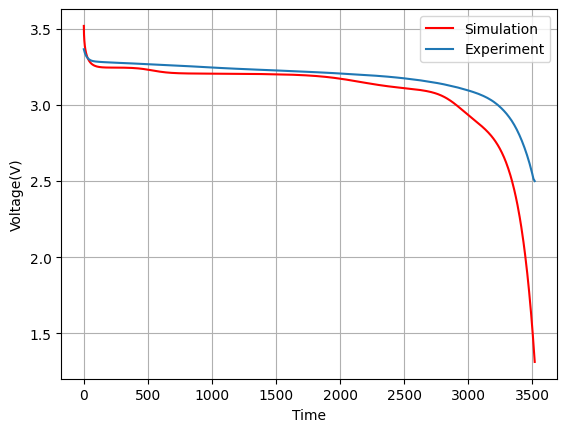

In [ ]:
plt.plot(sol["Time [s]"].data, sol["Terminal voltage [V]"].data,'red') # default pybamm Prada set OCVs value
plt.plot(df_dis_2['Timeseries'], df_dis_2['Voltage']) # Experimental graph
plt.legend(['Simulation','Experiment'])
plt.xlabel('Time')
plt.ylabel('Voltage(V)')
plt.grid()

In [ ]:
for j in Sel_Pos_OCV:
  params.update({"Positive electrode OCP [V]":j})
  for i in Sel_Neg_OCV:
    nocp_data=i
    np.array(nocp_data)
    params.update({"Negative electrode OCP [V]":("half_cell_Negative",nocp_data)})
    sim = pybamm.Simulation(model, parameter_values=params,experiment=experiment,solver=pybamm.IDAKLUSolver(rtol=0.0001, atol=1e-06, root_method='casadi', root_tol=1e-06, extrap_tol=None, output_variables=None, options=None))
    sol=sim.solve()
    simulation_Graphite_array.append(sim)


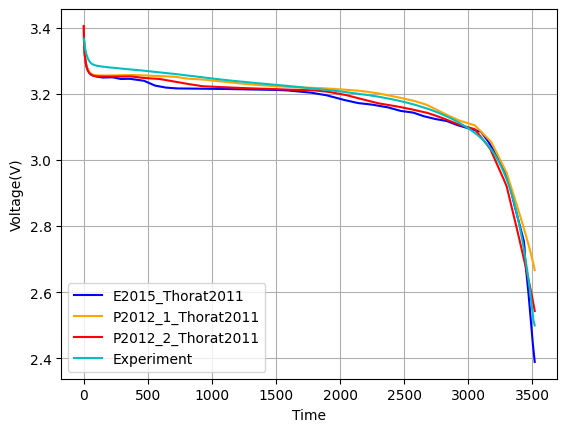

In [ ]:
plt.plot(simulation_Graphite_array[1].solution["Time [s]"].data, simulation_Graphite_array[1].solution["Terminal voltage [V]"].data,'blue',label='E2015_Thorat2011')
plt.plot(simulation_Graphite_array[2].solution["Time [s]"].data, simulation_Graphite_array[2].solution["Terminal voltage [V]"].data,'orange',label='P2012_1_Thorat2011')
plt.plot(simulation_Graphite_array[3].solution["Time [s]"].data, simulation_Graphite_array[3].solution["Terminal voltage [V]"].data,'r',label='P2012_2_Thorat2011')
plt.plot(df_dis_2['Timeseries'],df_dis_2['Voltage'],color='c',label='Experiment')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Voltage(V)')
plt.grid()

Finally selected oCV are:

Negative OCV: **Prada2012(P2012)**
Positive OCV: **Thorat2011**

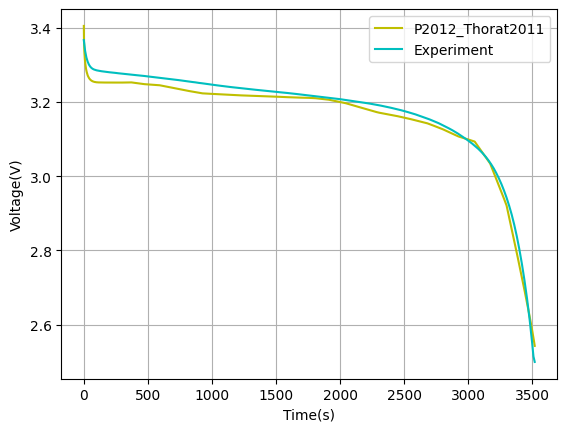

In [ ]:
plt.plot(simulation_Graphite_array[3].solution["Time [s]"].data, simulation_Graphite_array[3].solution["Terminal voltage [V]"].data,'y')
plt.plot(df_dis_2['Timeseries'],df_dis_2['Voltage'],color='c')
plt.legend(['P2012_Thorat2011','Experiment'])
plt.xlabel('Time(s)')
plt.ylabel('Voltage(V)')
plt.grid()

In [ ]:
Final_Neg_OCV=Sel_Neg_OCV[2]
Final_Pos_OCV=Sel_Pos_OCV[0]